In [7]:
import pandas as pd
import re
import ast
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Download necessary NLTK resources
#nltk.download("stopwords")
#nltk.download('punkt_tab')

### From part 1

In [8]:
# Initialize stopwords and stemmer
stop_words = set(stopwords.words("english"))                        # load English stopwords from NLTK
stemmer = PorterStemmer()                                           # create a new Porter stemmer 

In [9]:
# Define text preprocessing functions
def clean_text(text):
    text = text.lower()                                             # convert to lowercase
    spaces = re.compile(r'\s+')
    text = spaces.sub(' ', text)                                    # substitute all white space characters (single or multiple occurences) with a single space

    emails = re.compile(r'\S+@\S+\.\S+')
    text = emails.sub('_EMAIL_', text)                              # substitute all found email addresses with _EMAIL_
    urls = re.compile(r'http[s]?:\/\/\S+|www\.\S+|\S+\.[a-z]+\/\S+|\w+\.(?:com|net|org)')
    text = urls.sub('_URL_', text)                                  # substitute all found URLs with _URL_
    dates = re.compile(r'''
                       \d{1,4}[-\/]\d{1,2}[-\/]\d{1,4}|
                       \d{1,2}\ (?:jan[a-z]*|feb[a-z]*|mar[a-z]*|apr[a-z]*|may|jun[e]?|jul[y]?|aug[a-z]*|sep[a-z]*|oct[a-z]*|nov[a-z]*|dec[a-z]*)\ \d{,4}|
                       (?:jan[a-z]*|feb[a-z]*|mar[a-z]*|apr[a-z]*|may|jun[e]?|jul[y]?|aug[a-z]*|sep[a-z]*|oct[a-z]*|nov[a-z]*|dec[a-z]*)[,.]?\ ?\d{1,4}(?:th|st|nd|rd)?(?:,\ \d{4})?
                       ''', re.VERBOSE)
    text = dates.sub('_DATE_', text)                                # substitute all found dates with _DATE_
    numbers = re.compile(r'\d+(?:th|st|nd|rd)?')
    text = numbers.sub('_NUM_', text)                               # substitute all remaining numbers with _NUM_
    return text

def remove_stopwords_and_stem(tokens):
    return [stemmer.stem(word) for word in tokens if word not in stop_words]

## Evaluating on Liar dataset

In [11]:
# File paths
liar_test = "test.tsv"
liar_processed = "liar_test.csv"

In [12]:
# Read and process test data from the LIAR dataset
liar_df = pd.read_csv(liar_test, sep = '\t', usecols=[1,2], names=['label', 'statement'])

# Apply text preprocessing pipeline
liar_df['statement'] = liar_df['statement'].apply(clean_text)                                   # cleaning the statements in the statement column
liar_df['statement'] = liar_df['statement'].apply(word_tokenize)                                # tokenizing the statements in the statement column
liar_df['stemmed_tokens'] = liar_df['statement'].apply(remove_stopwords_and_stem)               # removing stopwords and stemming the tokens 

# Convert data in 'stemmed_tokens' column from list of strings
# to a single string pr. article (as this is what e.g. CountVectorizer expects as input)
print(type(liar_df['stemmed_tokens'][0]))
print(liar_df['stemmed_tokens'].head(2))
liar_df['stemmed_tokens'] = liar_df['stemmed_tokens'].apply(lambda x: ' '.join(x))
print(type(liar_df['stemmed_tokens'][0]))
print(liar_df['stemmed_tokens'].head(2))


# Print overview of occuring labels 
print(liar_df['label'].value_counts())

fake_lables = ['pants-fire', 'false']
reliable_lables = ['true', 'mostly-true']

liar_df = liar_df[liar_df['label'].isin(fake_lables + reliable_lables)]                     # Keep only relevant labels
liar_df['label'] = liar_df['label'].apply(lambda x: 1 if x in fake_lables else 0)             # Convert the 'label' column to numerical values

print(liar_df['label'].value_counts())                                                      # Print the count of statements grouped as 'fake' or 'reliable'


# Write and save processed data to csv file
liar_df.to_csv(liar_processed, columns=['stemmed_tokens', 'label'], mode="w", index=False, header=True)

print("Processing complete! Data saved to:", liar_processed)

<class 'list'>
0    [build, wall, u.s.-mexico, border, take, liter...
1    [wisconsin, pace, doubl, number, layoff, year, .]
Name: stemmed_tokens, dtype: object
<class 'str'>
0    build wall u.s.-mexico border take liter year .
1          wisconsin pace doubl number layoff year .
Name: stemmed_tokens, dtype: object
label
half-true      265
false          249
mostly-true    241
barely-true    212
true           208
pants-fire      92
Name: count, dtype: int64
label
0    449
1    341
Name: count, dtype: int64
Processing complete! Data saved to: liar_test.csv


## Our model on the LIAR dataset

In [17]:
## noget kodeværk her

import pandas as pd
import numpy as np
from sklearn.experimental import enable_halving_search_cv 
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score, classification_report

train_data = pd.read_csv('train_data.csv', usecols=['stemmed_tokens', 'type'])
validation_data = pd.read_csv('validation_data.csv', usecols=['stemmed_tokens', 'type'])
test_data = pd.read_csv('liar_test.csv', usecols=['stemmed_tokens', 'label'])

X_train = train_data['stemmed_tokens']
y_train = train_data['type']
X_val = validation_data['stemmed_tokens']
y_val = validation_data['type']
X_test = test_data['stemmed_tokens'] 
y_test = test_data['label']

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,2))
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)  # Fixed typo

X_train_dense = X_train_tfidf.toarray() if hasattr(X_train_tfidf, "toarray") else X_train_tfidf
X_val_dense = X_val_tfidf.toarray() if hasattr(X_val_tfidf, "toarray") else X_val_tfidf
X_test_dense = X_test_tfidf.toarray() if hasattr(X_test_tfidf, "toarray") else X_test_tfidf

param_grid = {
    'penalty': ['l2', 'none'],
    'C': np.logspace(-4, 4, 10),
    'solver': ['liblinear', 'saga'],
    'max_iter': [100, 500, 1000, 5000]
}

search = HalvingRandomSearchCV(
    estimator=LogisticRegression(class_weight='balanced'),
    param_distributions=param_grid,
    cv=5,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

search.fit(X_train_dense, y_train)

y_val_pred = search.predict(X_val_dense)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_f1 = f1_score(y_val, y_val_pred, average='weighted')

print("Best Parameters:", search.best_params_)
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1 Score: {val_f1:.4f}")
print("Validation Classification Report:\n", classification_report(y_val, y_val_pred))

y_test_pred = search.predict(X_test_dense)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")


n_iterations: 5
n_required_iterations: 5
n_possible_iterations: 10
min_resources_: 20
max_resources_: 599891
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 160
n_resources: 20
Fitting 5 folds for each of 160 candidates, totalling 800 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 160 is smaller than n_iter=29994. Running 160 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-pack

----------
iter: 1
n_candidates: 54
n_resources: 60
Fitting 5 folds for each of 54 candidates, totalling 270 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max

----------
iter: 2
n_candidates: 18
n_resources: 180
Fitting 5 folds for each of 18 candidates, totalling 90 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.56666667 0.55              nan        nan 0.56666667 0.48333333
        nan        nan 0.56666667 0.45              nan        nan
 0.56666667 0.61666667        nan        nan 0.56666667 0.51666667
        nan        nan 0.56666667 0.45              nan        nan
 0.56666667 0.48333333        nan        nan 0.56666667 0.48333333
        nan        nan 0.56666667 0.68333333        nan        nan
 0.56666667 0.68333333        nan        nan 0.56666667 0.61666667
        nan        nan 0.56666667 0.63333333        nan        nan
 0.56666667 0.61666667        nan        nan 0.56666667 0.61666667
        nan        nan 0.56666667 0.61666667        nan        nan
 0.56666667 0.61666667        nan        nan 0.61666667 0.61666667
        nan        nan 0.61666667 0.61666667        nan        nan
 0.61666667 0.61666667        nan        nan 0.6166

----------
iter: 3
n_candidates: 6
n_resources: 540
Fitting 5 folds for each of 6 candidates, totalling 30 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.56666667 0.55              nan        nan 0.56666667 0.48333333
        nan        nan 0.56666667 0.45              nan        nan
 0.56666667 0.61666667        nan        nan 0.56666667 0.51666667
        nan        nan 0.56666667 0.45              nan        nan
 0.56666667 0.48333333        nan        nan 0.56666667 0.48333333
        nan        nan 0.56666667 0.68333333        nan        nan
 0.56666667 0.68333333        nan        nan 0.56666667 0.61666667
        nan        nan 0.56666667 0.63333333        nan        nan
 0.56666667 0.61666667        nan        nan 0.56666667 0.61666667
        nan        nan 0.56666667 0.61666667        nan        nan
 0.56666667 0.61666667        nan        nan 0.61666667 0.61666667
        nan        nan 0.61666667 0.61666667        nan        nan
 0.61666667 0.61666667        nan        nan 0.6166

----------
iter: 4
n_candidates: 2
n_resources: 1620
Fitting 5 folds for each of 2 candidates, totalling 10 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [0.56666667 0.55              nan        nan 0.56666667 0.48333333
        nan        nan 0.56666667 0.45              nan        nan
 0.56666667 0.61666667        nan        nan 0.56666667 0.51666667
        nan        nan 0.56666667 0.45              nan        nan
 0.56666667 0.48333333        nan        nan 0.56666667 0.48333333
        nan        nan 0.56666667 0.68333333        nan        nan
 0.56666667 0.68333333        nan        nan 0.56666667 0.61666667
        nan        nan 0.56666667 0.63333333        nan        nan
 0.56666667 0.61666667        nan        nan 0.56666667 0.61666667
        nan        nan 0.56666667 0.61666667        nan        nan
 0.56666667 0.61666667        nan        nan 0.61666667 0.61666667
        nan        nan 0.61666667 0.61666667        nan        nan
 0.61666667 0.61666667        nan        nan 0.6166

Best Parameters: {'solver': 'saga', 'penalty': 'l2', 'max_iter': 1000, 'C': np.float64(2.782559402207126)}
Validation Accuracy: 0.8713
Validation F1 Score: 0.8714
Validation Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.88     39216
           1       0.86      0.87      0.87     35770

    accuracy                           0.87     74986
   macro avg       0.87      0.87      0.87     74986
weighted avg       0.87      0.87      0.87     74986

Test Accuracy: 0.5241
Test F1 Score: 0.5259


# Confusion Matrix

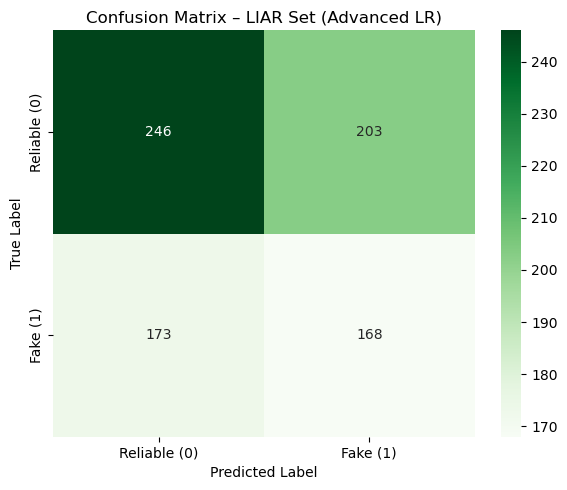

Confusion Matrix:
 [[246 203]
 [173 168]]


: 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix


cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Reliable (0)', 'Fake (1)'],
            yticklabels=['Reliable (0)', 'Fake (1)'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix – LIAR Set (Advanced LR)")
plt.tight_layout()
plt.show()

print("Confusion Matrix:\n", cm)
